### **We use the landsat5789-s2-based prtrained model (pytorch-based) for glacier mapping**


In [1]:
import os
os.chdir('..')
import torch
import numpy as np
import rasterio as rio
from utils.imgPatch import imgPatch
from model.model.unet import unet
from utils.imgShow import imsShow
from utils.dataloader import read_normalize


In [2]:
path_img = 'data/dset-l5789-s2/scene/l5_scene_01_Dem.tif'
path_wat_pred = 'data/result/l5_scene_01_pred.tif'   ## path to save result
path_trained_model = 'model/trained/unet_l5789_s2.pth'


In [3]:
## load trained model
model = unet(num_bands=7)
model.load_state_dict(torch.load(path_trained_model, weights_only=True))


<All keys matched successfully>

In [4]:
### surface water mapping by using trained model
print('image:', path_img)
### --- 1. read in satellite images 
with rio.open(path_img) as src:
    img = src.read().transpose(1, 2, 0)  # change to channel last format
    img_meta = src.meta # obtain metadata for writing result
# img = np.float32(np.clip(img/10000, a_min=0, a_max=1))     ### normalization
img = read_normalize(img)
### ---- 2. surface water mapping using trained model 
imgPat_ins = imgPatch(img=img, patch_size=512, edge_overlay = 160)
patch_list, start_list, img_patch_row, img_patch_col = imgPat_ins.toPatch()
patch_list = [torch.from_numpy(patch.transpose(2,0,1)).float() for patch in patch_list]  # 1.channel first and 2.numpy array to torch tensor
result_patch_list = [model(patch[np.newaxis, :]) for patch in patch_list]
result_patch_list = [np.squeeze(patch.detach().numpy().transpose(0,2,3,1), axis = 0) 
                                for patch in result_patch_list]       ## 1.channel last and 2.torch tensor to numpy array
pro_pred = imgPat_ins.toImage(result_patch_list, img_patch_row, img_patch_col)
cla_pred = np.where(pro_pred>0.5, 1, 0).squeeze()
cla_pred = np.int8(cla_pred)


image: data/dset-l5789-s2/scene/l5_scene_01_Dem.tif


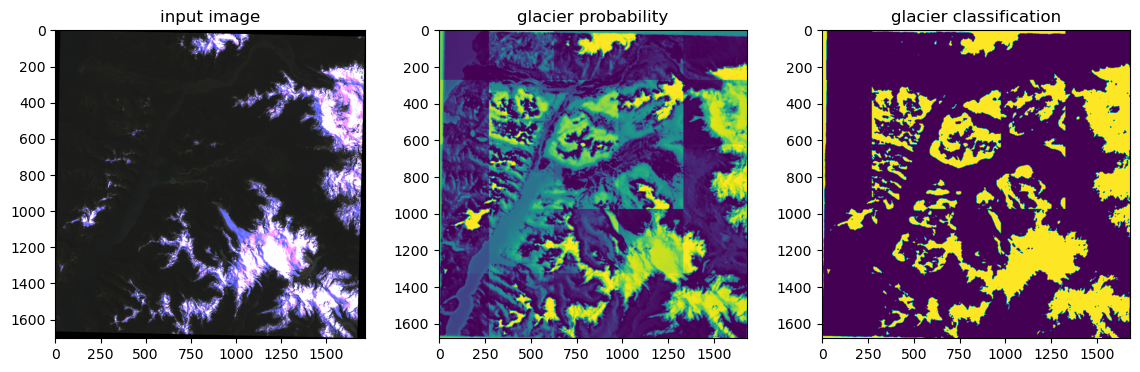

In [5]:
### show the results
imsShow([img, pro_pred, cla_pred],
         ['input image', 'glacier probability', 'glacier classification'],
         figsize=(14, 4))


In [6]:
# ### write the result to path
# with rio.open(path_wat_pred, 'w', driver='GTiff',
#              height=cla_pred.shape[0],
#              width=cla_pred.shape[1],
#              count=1,
#              dtype=np.int8,
#              crs=img_meta['crs'],
#              transform=img_meta['transform']) as dst:
#     dst.write(cla_pred, 1)  


In [7]:
# ## load and show the image and the prediction map
# with rio.open(path_img) as img_src, rio.open(path_wat_pred) as pred_src:
#     img_arr = img_src.read().transpose(1, 2, 0)  # change to channel last format
#     pred_arr = pred_src.read(1)   # read the first band (the classification result)
# imsShow([img_arr, pred_arr], ['input image', 'water prediction'], figsize=(8, 3))
